In [1]:
project_path = "/content/drive/MyDrive/swm/"

In [2]:
from zipfile import ZipFile
with ZipFile(project_path+'glove.6B.zip', 'r') as z:
  z.extractall()

In [3]:
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Activation, Dot, Reshape, Flatten 
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
train_bodies = pd.read_csv(project_path+'train_body.csv')
train_bodies.head()
train_stances = pd.read_csv(project_path+'train_stance.csv')
train_stances.head()

,Unnamed: 0,parent_tweet,id,classification
0,0,"Heard that friend was not going to be ""charged...",501760642928635904,comment
1,1,Name of Ferguson cop is expected to be release...,500270212198174720,comment
2,2,"no, radical Muslim extremists are making us vi...",524971210275565568,comment
3,3,URGENT: gunmen involved in deadly attack on C...,552836882770690049,comment
4,4,Did anyone think of comparing the clothes that...,500289931097296897,support


In [5]:

dataset = pd.merge(left=train_bodies, right=train_stances, left_on='id', right_on='id')
dataset.head(500)

,Unnamed: 0_x,id,tweet,Unnamed: 0_y,parent_tweet,classification
0,0,501760642928635904,This shows Michael paid for cigarillos. No rob...,0,"Heard that friend was not going to be ""charged...",comment
1,1,500270212198174720,Get ready to tweet the address SpikeLee and ot...,1,Name of Ferguson cop is expected to be release...,comment
2,2,524971210275565568,your radical Muslims are being funded by Ameri...,2,"no, radical Muslim extremists are making us vi...",comment
3,3,552836882770690049,Just kill them.,3,URGENT: gunmen involved in deadly attack on C...,comment
4,4,500289931097296897,"no, because that would require reasoning and t...",4,Did anyone think of comparing the clothes that...,support
...,...,...,...,...,...,...
495,495,552833887261691905,OK Drills Since Where Drill = Actual Terrori...,495,URGENT: gunmen involved in deadly attack on C...,comment
496,496,544295112545538048,“TheAnonMessage: FIRST PHOTOS: Hostage pressed...,496,FIRST PHOTOS: Hostage pressed against a window...,comment
497,497,544763686858944512,“chookelini: no way he's a right wing extremist”,497,no way he's a right wing extremist,comment
498,498,553545342055354368,MT French police publish photos of suspect in ...,498,French police publishes photos of suspect in y...,support


In [6]:
print(dataset)

      Unnamed: 0_x                  id  \
0                0  501760642928635904   
1                1  500270212198174720   
2                2  524971210275565568   
3                3  552836882770690049   
4                4  500289931097296897   
...            ...                 ...   
3959          3959  553505863827079168   
3960          3960  544284128615473152   
3961          3961  500302889429241856   
3962          3962  544293668513792000   
3963          3963  500320873086476288   

                                                  tweet  Unnamed: 0_y  \
0     This shows Michael paid for cigarillos. No rob...             0   
1     Get ready to tweet the address SpikeLee and ot...             1   
2     your radical Muslims are being funded by Ameri...             2   
3                                       Just kill them.             3   
4     no, because that would require reasoning and t...             4   
...                                                 ...  

In [7]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

In [8]:
t = Tokenizer(num_words=MAX_NB_WORDS)

In [9]:
t.fit_on_texts(dataset['tweet'].astype(str))
t.fit_on_texts(dataset['parent_tweet'].astype(str))
vocab_size = len(t.word_index.items())
vocab_size

6514

In [10]:
print(t.word_index['possible'])

777


In [11]:

texts = dataset['tweet']
texts[0]

'This shows Michael paid for cigarillos. No robbery, no crime! Pls RT'

In [12]:

articles = ['' for i in range(len(texts))]

# initialize
rows = len(texts)
cols = MAX_SENTS
articles_sent = [ ([''] * cols) for row in range(rows) ] # initialize 2d list

In [13]:
# Sentences are populated
for i in range(len(texts)):
  articles[i] = sent_tokenize(str(texts[i]))
  j=0
  for sentence in articles[i]:
    articles_sent[i][j] = sentence
    j = j+1
    if j == 20: break

In [14]:

articles_sent[0][0]

'This shows Michael paid for cigarillos.'

In [15]:
articles[0]

['This shows Michael paid for cigarillos.', 'No robbery, no crime!', 'Pls RT']

In [16]:
# Initialize data 
data = np.zeros((len(articles), MAX_SENTS, MAX_SENT_LENGTH), dtype=int)
data.shape

(3964, 20, 20)

In [17]:
# Populate 3d array - iterating through the words in each sentence, and sentences in each article.
i=0
j=0
k=0

for i in range(len(articles)):
  for j in range(len(articles_sent[i])):
    result = text_to_word_sequence(''.join(articles_sent[i][j]))
    if j==19: break
    for k in range(len(result)):
        data[i][j][k] = t.word_index[result[k]]
        if k==19: break

In [18]:
data[0, :, :]

array([[  20,  283,  116,  911,   13, 1928,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  32,   45,   32,  346,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [2515,  127,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    

In [19]:
# Populate text heading
texts_heading = dataset['parent_tweet']
texts_heading[0]

'Heard that friend was not going to be "charged" in any robbery since video shows it was other person'

In [20]:
# Initialize heading array 
articles_heading = ['' for i in range(len(texts_heading))]

# initialize 2d list for heading sentences
rows = len(texts)
cols = MAX_SENTS_HEADING
articles_heading_sent = [ ([''] * cols) for row in range(rows) ] # initialize 2d list

In [21]:
# Separate heading sentences 
for i in range(len(texts_heading)):
  articles_heading[i] = sent_tokenize(str(texts_heading[i]))
  j=0  
  for sentence in articles_heading[i]:
    articles_heading_sent[i][j] = sentence

In [22]:
# Check if heading sentence populated correctly 
articles_heading_sent[499][0]

'Police have surrounded this building where the suspected CharlieHebdo attackers are holed-up'

In [23]:
# Initialize data heading 
data_heading = np.zeros((len(articles_heading), MAX_SENTS_HEADING, MAX_SENT_LENGTH), dtype=int)
data_heading.shape

(3964, 1, 20)

In [24]:
# Populate 3d array - iterating through the words in each sentence, and sentences in each heading.
i=0
j=0
k=0
for i in range(len(articles_heading)):
  for j in range(len(articles_heading_sent[i])):
    result = text_to_word_sequence(''.join(articles_heading_sent[i][j]))
    for k in range(len(result)):
      data_heading[i][j][k] = t.word_index[result[k]]
      if k==19: break

In [25]:
data_heading[0, :, :]

array([[312,  10, 697,  14,  18, 390,   3,  24, 266,   2, 174,  45, 626,
        125, 283,  19,  14, 185, 180,   0]])

In [26]:
# Load stance data from main dataset 
stance = dataset['classification']
stance[499]

'support'

In [27]:
# Populate labels as array 
labels = np.asarray(pd.get_dummies(stance))

In [28]:
# Check shapes of data, data heading and labels arrays 
print('Shape of data tensor:', data.shape)
print('Shape of data heading tensor:', data_heading.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (3964, 20, 20)
Shape of data heading tensor: (3964, 1, 20)
Shape of label tensor: (3964, 4)


In [29]:
# Check one sample one-hot encoded label 
print(labels[499][:])

[0 0 0 1]


In [30]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [31]:
## shuffle the data
data = data[indices]
data_heading = data_heading[indices]
## shuffle the labels according to data
labels = labels[indices]

In [32]:
# Split in train and test for articles as well as headings data, using same random state 
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=21)
x_heading_train, x_heading_val, y_train, y_val  = train_test_split(data_heading, labels, test_size=0.2, random_state=21)

In [33]:
# Check shapes of all train and test arrays 
print(x_train.shape)
print(x_heading_train.shape)
print(y_train.shape)

print(x_val.shape)
print(x_heading_val.shape)
print(y_val.shape)

(3171, 20, 20)
(3171, 1, 20)
(3171, 4)
(793, 20, 20)
(793, 1, 20)
(793, 4)


In [34]:
# Load the whole embedding into memory

embeddings_index = dict()
f = open('./glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# Create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [35]:
# Check length of embedding matrix, should be equal to vocabulary size 
len(embedding_matrix)

6514

In [36]:
x_train_resh = x_train.reshape(3171, 400)
x_val_resh = x_val.reshape(793, 400)

In [37]:
x_heading_train_resh = x_heading_train.reshape(3171, 20)
x_heading_val_resh = x_heading_val.reshape(793, 20)

In [38]:
# Check shapes after resizing 
print(x_train_resh.shape)
print(x_heading_train_resh.shape)
print(y_train.shape)

print(x_val_resh.shape)
print(x_heading_val_resh.shape)
print(y_val.shape)

(3171, 400)
(3171, 20)
(3171, 4)
(793, 400)
(793, 20)
(793, 4)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 300)     1954200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 300)      1954200     ['input_2[0][0]']                
                                                                                              

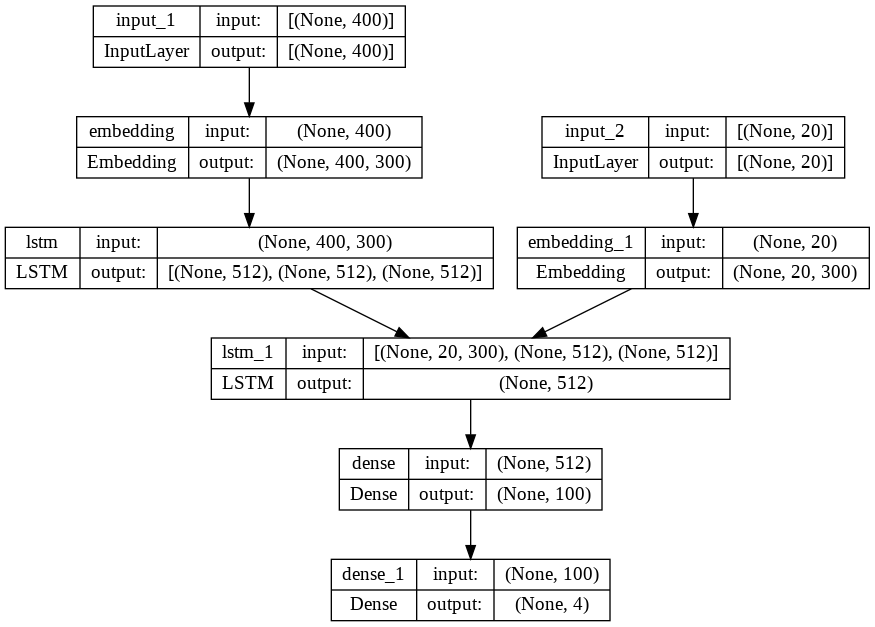

In [39]:
encoder_inputs = Input(shape=(400,))
x = Embedding(vocab_size, 300, weights=[embedding_matrix], 
              trainable=False)(encoder_inputs)
x, state_h, state_c = LSTM(units=512,
                           return_state=True)(x)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(20,))
x = Embedding(vocab_size, 300, weights=[embedding_matrix], 
              trainable=False)(decoder_inputs)
x = LSTM(units=512, return_sequences=False)(x, initial_state=encoder_states)
x = Dense(100, input_shape=(512,), activation='relu')(x)
decoder_outputs = Dense(4, activation='softmax')(x)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:

encoder_inputs = Input(shape=(400,))
enc = Embedding(vocab_size, 300, weights=[embedding_matrix], 
              trainable=False)(encoder_inputs)
enc, state_h, state_c = LSTM(units=512, return_sequences=True,
                           return_state=True)(enc)
encoder_states = [state_h, state_c]

att_vector = TimeDistributed(Dense(1,input_shape=(512,)))(enc)
att_vector_res = Reshape([400])(att_vector)
att_vector_res = Activation('softmax', name='attention_vec')(att_vector_res)


decoder_inputs = Input(shape=(20,))
dec = Embedding(vocab_size, 300, weights=[embedding_matrix], 
              trainable=False)(decoder_inputs)
dec = LSTM(units=512, return_sequences=True)(dec, initial_state=encoder_states)
dec = Dense(20)(dec)
dec_res = Reshape([400])(dec)
 
att_output = Dot(axes=1)([dec_res, att_vector_res])

dec_res = Dense(100, input_shape=(1,), activation='relu')(att_output)
decoder_outputs = Dense(4, activation='softmax')(dec_res)

model_att = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model_att.summary()
plot_model(model_att, to_file='model_att.png', show_shapes=True)

In [40]:

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:

%%time
model.fit(x=[x_train_resh, x_heading_train_resh],
          y=y_train,
          batch_size=64,
          epochs=6,
          validation_data=([x_val_resh, x_heading_val_resh],y_val))

Epoch 1/6
50/50 [==============================] - 454s 9s/step - loss: 0.8711 - accuracy: 0.6881 - val_loss: 0.9136 - val_accuracy: 0.7188
Epoch 2/6
50/50 [==============================] - 459s 9s/step - loss: 0.8441 - accuracy: 0.6916 - val_loss: 0.9452 - val_accuracy: 0.7011
Epoch 3/6
50/50 [==============================] - 455s 9s/step - loss: 0.8260 - accuracy: 0.6894 - val_loss: 0.8973 - val_accuracy: 0.7087
Epoch 4/6
50/50 [==============================] - 459s 9s/step - loss: 0.8112 - accuracy: 0.6960 - val_loss: 0.9344 - val_accuracy: 0.7011
Epoch 5/6
50/50 [==============================] - 451s 9s/step - loss: 0.7834 - accuracy: 0.7010 - val_loss: 1.1106 - val_accuracy: 0.5826
Epoch 6/6
50/50 [==============================] - 453s 9s/step - loss: 0.7654 - accuracy: 0.7010 - val_loss: 0.9831 - val_accuracy: 0.6860
CPU times: user 1h 21min 33s, sys: 2min 14s, total: 1h 23min 48s
Wall time: 45min 31s


In [43]:

yhat = model.predict([x_val_resh, x_heading_val_resh], verbose=1)

25/25 [==============================] - 41s 2s/step


In [45]:

for i in range(10):
  a = (random.randint(1,793))
  print("Index",a) 
  print("Predicted:",yhat[a][:])
  print("Actual:",y_val[a][:])

Index 112
Predicted: [0.8648608  0.03595369 0.06792412 0.03126141]
Actual: [1 0 0 0]
Index 157
Predicted: [0.5738775  0.24444687 0.09144796 0.09022769]
Actual: [1 0 0 0]
Index 436
Predicted: [0.46520537 0.17679076 0.00890779 0.349096  ]
Actual: [1 0 0 0]
Index 772
Predicted: [0.58667135 0.11742009 0.01325511 0.28265345]
Actual: [1 0 0 0]
Index 200
Predicted: [0.9630594  0.00590649 0.002883   0.02815107]
Actual: [0 0 0 1]
Index 125
Predicted: [0.91148764 0.02609058 0.00593286 0.05648888]
Actual: [1 0 0 0]
Index 269
Predicted: [0.7846613  0.01422252 0.07462184 0.12649427]
Actual: [0 0 0 1]
Index 368
Predicted: [0.95060563 0.00633141 0.01499029 0.02807272]
Actual: [1 0 0 0]
Index 419
Predicted: [0.65595007 0.02251139 0.00396031 0.31757808]
Actual: [1 0 0 0]
Index 727
Predicted: [0.8012025  0.03381534 0.00276724 0.16221495]
Actual: [1 0 0 0]


In [46]:
loss, accuracy = model.evaluate([x_val_resh, x_heading_val_resh], y_val)
print('Accuracy :',round((accuracy*100),2),'%')

25/25 [==============================] - 38s 2s/step - loss: 0.9831 - accuracy: 0.6860
Accuracy : 68.6 %


In [47]:
from sklearn.metrics import classification_report
y_pred1 = model.predict([x_val_resh, x_heading_val_resh])
y_pred = np.argmax(y_pred1, axis=1)



25/25 [==============================] - 39s 2s/step


In [48]:
y_train_l = np.argmax(y_val, axis=1)

print(y_train_l.shape, y_pred.shape)
print(y_train_l[:5], y_pred[:5])

(793,) (793,)
[2 3 0 0 0] [0 1 0 0 0]


In [49]:
print(classification_report(y_train_l, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.93      0.82       567
           1       0.07      0.04      0.05        56
           2       0.29      0.09      0.14        55
           3       0.38      0.10      0.16       115

    accuracy                           0.69       793
   macro avg       0.37      0.29      0.29       793
weighted avg       0.60      0.69      0.62       793

